# Lyrics Analysis: Word Counts & Song Structure

> **Disclaimer**: This notebook was generated by Claude Opus 4.5

Analyzes:
- Total words per song
- Unique words (excluding stop words)
- Song structure (verses, choruses, bridges)


In [1]:
import re
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

DATA_DIR = Path('data')
CACHE_DIR = Path('cache/lyrics')


In [2]:
# Stop words to exclude from unique word counts
STOP_WORDS = {
    # Articles
    'a', 'an', 'the',
    # Prepositions
    'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from', 'up', 'down',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'between',
    'under', 'over', 'out', 'off', 'about', 'against', 'around',
    # Pronouns
    'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves',
    'they', 'them', 'their', 'theirs', 'themselves',
    'this', 'that', 'these', 'those', 'who', 'whom', 'whose', 'which', 'what',
    # Conjunctions
    'and', 'but', 'or', 'nor', 'so', 'yet', 'both', 'either', 'neither',
    'not', 'only', 'if', 'then', 'because', 'as', 'while', 'when', 'where',
    # Common verbs
    'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'done',
    'will', 'would', 'could', 'should', 'may', 'might', 'must', 'shall', 'can',
    # Contractions
    've', 'll', 're', 'd', 's', 't', 'm', 'don', 'won', 'didn', 'doesn', 
    'isn', 'aren', 'wasn', 'weren', 'couldn', 'wouldn', 'shouldn', 'ain',
    # Common adverbs
    'just', 'now', 'here', 'there', 'very', 'really', 'too', 'also',
    'still', 'already', 'always', 'never', 'ever', 'even',
    # Other common words
    'all', 'some', 'any', 'no', 'none', 'more', 'most', 'other', 'another',
    'such', 'each', 'every', 'many', 'much', 'few', 'little', 'own',
    'same', 'than', 'like', 'well', 'back', 'way', 'got', 'get', 'let',
    # Vocal sounds
    'oh', 'ah', 'ooh', 'yeah', 'hey', 'uh', 'na', 'la', 'da', 'ba', 'whoa', 
    'woah', 'ay', 'aye', 'mm', 'hmm', 'woo',
}


In [3]:
def clean_text(text):
    """Clean lyrics text for word analysis."""
    if not text or pd.isna(text):
        return ''
    text = re.sub(r'\[.*?\]', '', text)  # Remove section markers
    text = re.sub(r'\d*Embed$', '', text)  # Remove Genius artifacts
    text = re.sub(r'You might also like', '', text, flags=re.IGNORECASE)
    return text.lower()

def get_words(text):
    """Extract all words from text."""
    text = clean_text(text)
    return re.findall(r"[a-z']+", text)

def get_unique_words(text, exclude_stop=True):
    """Get unique words, optionally excluding stop words."""
    words = get_words(text)
    if exclude_stop:
        words = [w for w in words if w not in STOP_WORDS and len(w) > 1]
    return set(words)

def detect_structure(text):
    """Detect song structure from lyrics."""
    if not text or pd.isna(text):
        return {'sections': 0, 'has_markers': False, 'estimated_type': 'unknown'}
    
    markers = re.findall(r'\[(.*?)\]', text, re.IGNORECASE)
    has_markers = len(markers) > 0
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
    section_count = len(paragraphs)
    
    if has_markers:
        marker_types = set(m.lower().split()[0] for m in markers if m)
        if 'chorus' in marker_types and 'verse' in marker_types:
            est_type = 'verse-chorus'
        elif 'verse' in marker_types:
            est_type = 'verse-based'
        else:
            est_type = 'marked-sections'
    else:
        if section_count <= 2:
            est_type = 'minimal'
        elif section_count <= 5:
            est_type = 'standard'
        else:
            est_type = 'extended'
    
    return {'sections': section_count, 'has_markers': has_markers, 'marker_count': len(markers), 'estimated_type': est_type}


In [4]:
# Load latest compiled lyrics
csv_files = sorted(DATA_DIR.glob('compiled_lyrics_*.csv'), reverse=True)
if not csv_files:
    raise FileNotFoundError('No compiled_lyrics_*.csv found')

df = pd.read_csv(csv_files[0])
print(f'Loaded: {csv_files[0].name}')
print(f'Total tracks: {len(df)}')
print(f'With lyrics: {df["has_lyrics"].sum()}')


Loaded: compiled_lyrics_20251207.csv
Total tracks: 782
With lyrics: 618


In [5]:
# Load full lyrics from cache (CSV has truncated versions)
def load_full_lyrics(row):
    """Load full lyrics from cache file."""
    # Column is 'lyrics_cache_path', not 'lyrics_path'
    cache_path = row.get('lyrics_cache_path')
    if pd.isna(cache_path) or not cache_path:
        return row.get('lyrics', '') or ''
    path = Path(cache_path)
    if path.exists():
        return path.read_text(encoding='utf-8')
    return row.get('lyrics', '') or ''

df['full_lyrics'] = df.apply(load_full_lyrics, axis=1)
print(f'Loaded full lyrics for {(df["full_lyrics"] != "").sum()} tracks')


Loaded full lyrics for 782 tracks


In [6]:
# Calculate metrics
df['total_words'] = df['full_lyrics'].apply(lambda x: len(get_words(x)))
df['unique_words'] = df['full_lyrics'].apply(lambda x: len(get_unique_words(x, exclude_stop=True)))
df['unique_ratio'] = df.apply(lambda r: r['unique_words'] / r['total_words'] if r['total_words'] > 0 else 0, axis=1)

# Structure analysis
structure_data = df['full_lyrics'].apply(detect_structure)
df['sections'] = structure_data.apply(lambda x: x['sections'])
df['has_markers'] = structure_data.apply(lambda x: x['has_markers'])
df['structure_type'] = structure_data.apply(lambda x: x['estimated_type'])

# Filter to songs with lyrics
df_lyrics = df[df['total_words'] > 0].copy()
print(f'Songs with lyrics: {len(df_lyrics)}')


Songs with lyrics: 618


In [7]:
# Summary statistics
print('=== Word Count Statistics ===')
print(f"Total words: {df_lyrics['total_words'].mean():.0f} avg, {df_lyrics['total_words'].median():.0f} median")
print(f"Unique words: {df_lyrics['unique_words'].mean():.0f} avg, {df_lyrics['unique_words'].median():.0f} median")
print(f"Unique ratio: {df_lyrics['unique_ratio'].mean():.2f} avg")
print(f"\nSections per song: {df_lyrics['sections'].mean():.1f} avg, {df_lyrics['sections'].median():.0f} median")
print(f"Songs with section markers: {df_lyrics['has_markers'].sum()} ({df_lyrics['has_markers'].mean()*100:.0f}%)")


=== Word Count Statistics ===
Total words: 238 avg, 208 median
Unique words: 56 avg, 47 median
Unique ratio: 0.24 avg

Sections per song: 6.0 avg, 6 median
Songs with section markers: 0 (0%)


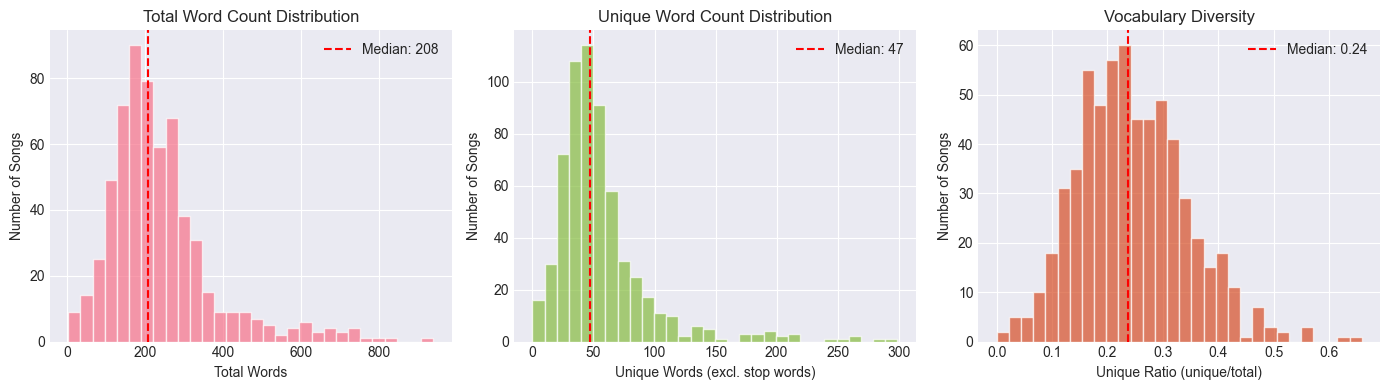

In [8]:
# Figure 1: Word count distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Total words
axes[0].hist(df_lyrics['total_words'], bins=30, edgecolor='white', alpha=0.7)
axes[0].axvline(df_lyrics['total_words'].median(), color='red', linestyle='--', label=f"Median: {df_lyrics['total_words'].median():.0f}")
axes[0].set_xlabel('Total Words')
axes[0].set_ylabel('Number of Songs')
axes[0].set_title('Total Word Count Distribution')
axes[0].legend()

# Unique words
axes[1].hist(df_lyrics['unique_words'], bins=30, edgecolor='white', alpha=0.7, color='#87bc40')
axes[1].axvline(df_lyrics['unique_words'].median(), color='red', linestyle='--', label=f"Median: {df_lyrics['unique_words'].median():.0f}")
axes[1].set_xlabel('Unique Words (excl. stop words)')
axes[1].set_ylabel('Number of Songs')
axes[1].set_title('Unique Word Count Distribution')
axes[1].legend()

# Unique ratio
axes[2].hist(df_lyrics['unique_ratio'], bins=30, edgecolor='white', alpha=0.7, color='#d74e26')
axes[2].axvline(df_lyrics['unique_ratio'].median(), color='red', linestyle='--', label=f"Median: {df_lyrics['unique_ratio'].median():.2f}")
axes[2].set_xlabel('Unique Ratio (unique/total)')
axes[2].set_ylabel('Number of Songs')
axes[2].set_title('Vocabulary Diversity')
axes[2].legend()

plt.tight_layout()
plt.savefig('output/word_count_distributions_20251207.png', dpi=150, bbox_inches='tight')
plt.show()


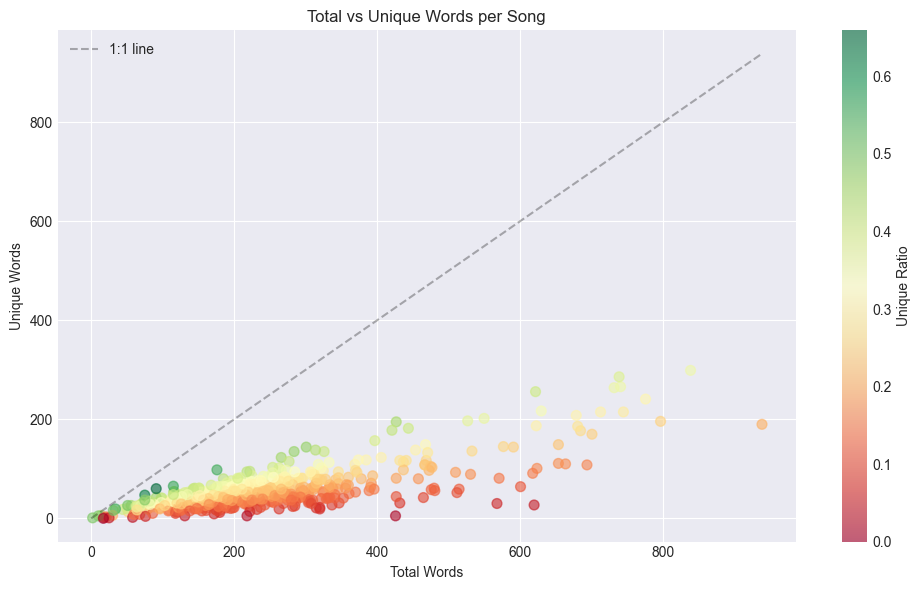

In [9]:
# Figure 2: Total vs Unique words scatter
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df_lyrics['total_words'], 
    df_lyrics['unique_words'],
    c=df_lyrics['unique_ratio'],
    cmap='RdYlGn',
    alpha=0.6,
    s=50
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Unique Ratio')

max_val = max(df_lyrics['total_words'].max(), df_lyrics['unique_words'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='1:1 line')

ax.set_xlabel('Total Words')
ax.set_ylabel('Unique Words')
ax.set_title('Total vs Unique Words per Song')
ax.legend()

plt.tight_layout()
plt.savefig('output/total_vs_unique_20251207.png', dpi=150, bbox_inches='tight')
plt.show()


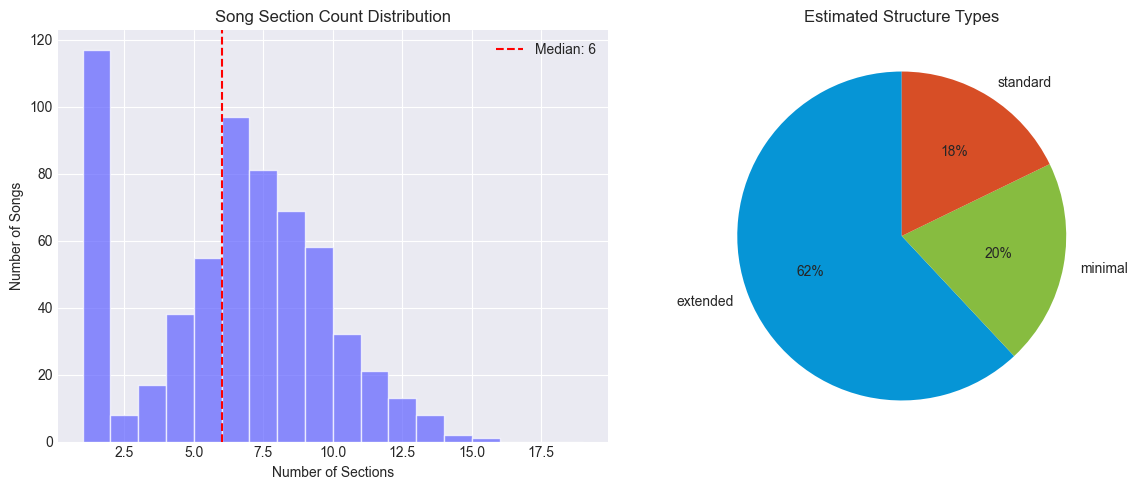

In [10]:
# Figure 3: Song structure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sections histogram
axes[0].hist(df_lyrics['sections'], bins=range(1, 20), edgecolor='white', alpha=0.7, color='#5f60ff')
axes[0].axvline(df_lyrics['sections'].median(), color='red', linestyle='--', label=f"Median: {df_lyrics['sections'].median():.0f}")
axes[0].set_xlabel('Number of Sections')
axes[0].set_ylabel('Number of Songs')
axes[0].set_title('Song Section Count Distribution')
axes[0].legend()

# Structure type pie
structure_counts = df_lyrics['structure_type'].value_counts()
colors = ['#0695d6', '#87bc40', '#d74e26', '#ffc21a', '#666666']
axes[1].pie(
    structure_counts.values, 
    labels=structure_counts.index,
    autopct='%1.0f%%',
    colors=colors[:len(structure_counts)],
    startangle=90
)
axes[1].set_title('Estimated Structure Types')

plt.tight_layout()
plt.savefig('output/song_structure_20251207.png', dpi=150, bbox_inches='tight')
plt.show()


In [11]:
# Top/Bottom tables
print('=== Most Words ===')
display(df_lyrics.nlargest(10, 'total_words')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))

print('\n=== Most Unique Words ===')
display(df_lyrics.nlargest(10, 'unique_words')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))

print('\n=== Highest Vocabulary Diversity (min 40 unique words) ===')
display(df_lyrics[df_lyrics['unique_words'] >= 40].nlargest(10, 'unique_ratio')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))

print('\n=== Most Repetitive (min 100 words) ===')
display(df_lyrics[df_lyrics['total_words'] >= 100].nsmallest(10, 'unique_ratio')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))


# LEASTS cell: Show bottom 10 for each metric (with sensible min for unique_ratio)
print('\n=== Least Words ===')
display(df_lyrics.nsmallest(10, 'total_words')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))

print('\n=== Least Unique Words ===')
display(df_lyrics.nsmallest(10, 'unique_words')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))

print('\n=== Lowest Vocabulary Diversity (min 40 unique words) ===')
display(df_lyrics[df_lyrics['unique_words'] >= 40].nsmallest(10, 'unique_ratio')[['artist', 'track', 'total_words', 'unique_words', 'unique_ratio']].round(2).reset_index(drop=True))


=== Most Words ===


,artist,track,total_words,unique_words,unique_ratio
0,Skee-Lo,I Wish,939,190,0.20
1,De La Soul,Breakadawn,839,299,0.36
2,Beastie Boys,So What'cha Want,797,196,0.25
3,A Tribe Called Quest,Excursions,776,241,0.31
4,A Tribe Called Quest,Award Tour,745,215,0.29
5,Beastie Boys,Nonstop Disco Powerpack,741,266,0.36
6,Nas,Get Down,739,286,0.39
7,Beastie Boys,Too Many Rappers,732,264,0.36
8,Beastie Boys,Finger Lickin' Good,713,215,0.30
9,Kaori,Good Life,701,170,0.24



=== Most Unique Words ===


,artist,track,total_words,unique_words,unique_ratio
0,De La Soul,Breakadawn,839,299,0.36
1,Nas,Get Down,739,286,0.39
2,Beastie Boys,Nonstop Disco Powerpack,741,266,0.36
3,Beastie Boys,Too Many Rappers,732,264,0.36
4,Kool Keith,Poppa Large,622,256,0.41
5,A Tribe Called Quest,Excursions,776,241,0.31
6,Beastie Boys,Hey Ladies,630,217,0.34
7,A Tribe Called Quest,Award Tour,745,215,0.29
8,Beastie Boys,Finger Lickin' Good,713,215,0.30
9,Young M.C.,Bust a Move,679,208,0.31



=== Highest Vocabulary Diversity (min 40 unique words) ===


,artist,track,total_words,unique_words,unique_ratio
0,Fu Manchu,Eatin' Dust,91,60,0.66
1,The Bright Light Social Hour,Ghost Dance,75,47,0.63
2,Arcade Fire,Haiti,115,65,0.57
3,Armik,Rubia,176,98,0.56
4,Gold Chains,I Come From San Francisco,301,144,0.48
5,Pink Floyd,Learning to Fly,284,135,0.48
6,Mad Season,X-Ray Mind,116,54,0.47
7,Mad Season,X-Ray Mind - Live at The Moore,116,54,0.47
8,Beck,Hell Yes,266,123,0.46
9,How to Destroy Angels,The Space in Between,91,42,0.46



=== Most Repetitive (min 100 words) ===


,artist,track,total_words,unique_words,unique_ratio
0,Tom Morello,Where It’s At Ain’t What It Is (feat. Gary Cla...,426,5,0.01
1,The Cinematic Orchestra,Channel 1 Suite,218,5,0.02
2,Band of Horses,Is There a Ghost,131,5,0.04
3,Daryl Hall & John Oates,I Can't Go For That (No Can Do),620,27,0.04
4,The Prodigy,Spitfire,172,9,0.05
5,Pendulum,Hold Your Colour,568,30,0.05
6,The Avalanches,Close to You,320,19,0.06
7,Radio Citizen,The Hop (feat. Bajka),222,14,0.06
8,Death from Above 1979,Pull Out,180,12,0.07
9,Gorillaz,DARE,315,21,0.07



=== Least Words ===


,artist,track,total_words,unique_words,unique_ratio
0,The Champs,Tequila,2,1,0.50
1,Melt Yourself Down,Fix My Life,10,5,0.50
2,Mr. Oizo,Flat Beat,14,6,0.43
3,Jack White,Battle Cry,17,0,0.00
4,deadmau5,Charlie can't dance,18,2,0.11
5,The Black Keys,Have Mercy On Me,21,3,0.14
6,Khruangbin,People Everywhere (Still Alive),25,1,0.04
7,Interpol,Untitled,30,6,0.20
8,Desert Sessions,Nenada,31,16,0.52
9,Madlib,Mystic Bounce,34,19,0.56



=== Least Unique Words ===


,artist,track,total_words,unique_words,unique_ratio
0,Jack White,Battle Cry,17,0,0.00
1,The Champs,Tequila,2,1,0.50
2,Khruangbin,People Everywhere (Still Alive),25,1,0.04
3,Khruangbin,Mr. White,58,2,0.03
4,deadmau5,Charlie can't dance,18,2,0.11
5,The Black Keys,Have Mercy On Me,21,3,0.14
6,The Prodigy,Smack My Bitch Up,76,4,0.05
7,Tom Morello,Where It’s At Ain’t What It Is (feat. Gary Cla...,426,5,0.01
8,Band of Horses,Is There a Ghost,131,5,0.04
9,Melt Yourself Down,Fix My Life,10,5,0.50



=== Lowest Vocabulary Diversity (min 40 unique words) ===


,artist,track,total_words,unique_words,unique_ratio
0,Lenny Kravitz,Ride,465,42,0.09
1,Janet Jackson,That's the Way Love Goes,512,52,0.10
2,The Presidents of the United States of America,Kitty,427,44,0.10
3,M.I.A.,10 Dollar,601,64,0.11
4,Madonna,Sorry,515,59,0.11
5,The Knocks,Classic (feat. Powers) - The Knocks Sunrise Edit,353,41,0.12
6,M.I.A.,Galang,481,56,0.12
7,The Romantics,Talking in Your Sleep,341,41,0.12
8,The Cult,The Witch,329,40,0.12
9,Imagine Dragons,On Top of the World,476,58,0.12


In [12]:
# Artist vocabulary diversity (artists with 3+ songs)
artist_stats = df_lyrics.groupby('artist').agg({
    'total_words': 'mean',
    'unique_words': 'mean',
    'unique_ratio': 'mean',
    'track': 'count'
}).rename(columns={'track': 'song_count'})

artist_stats = artist_stats[artist_stats['song_count'] >= 3].sort_values('unique_ratio', ascending=False)

print('=== Artist Vocabulary Diversity (3+ songs) ===')
display(artist_stats.round(2).head(15))


=== Artist Vocabulary Diversity (3+ songs) ===


,total_words,unique_words,unique_ratio,song_count
artist,,,,
The Bright Light Social Hour,58.67,31.00,0.51,3
Primus,263.75,79.75,0.34,4
Them Crooked Vultures,234.40,79.40,0.34,5
The Black Angels,128.89,42.33,0.33,9
Beastie Boys,470.94,151.35,0.33,17
Beck,214.88,67.75,0.32,8
Mad Season,160.83,47.17,0.32,6
Creedence Clearwater Revival,163.33,49.67,0.31,3
The Heavy Eyes,122.00,35.25,0.31,4


/var/folders/sg/6lths7114yd32f8dbjvfc7w40000gp/T/ipykernel_72642/874745294.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


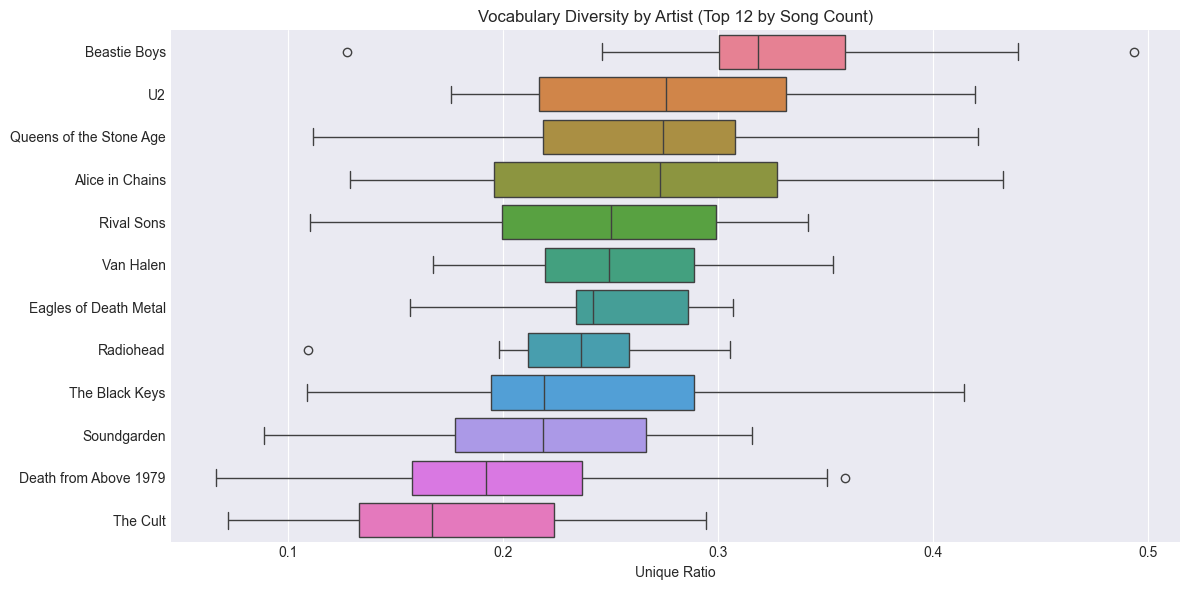

In [13]:
# Figure 4: Artist comparison (top artists by song count), horizontal boxplot
top_artists = df_lyrics['artist'].value_counts().head(12).index
df_top = df_lyrics[df_lyrics['artist'].isin(top_artists)]

fig, ax = plt.subplots(figsize=(12, 6))

artist_order = df_top.groupby('artist')['unique_ratio'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df_top,
    y='artist',
    x='unique_ratio',
    order=artist_order,
    palette='husl',
    ax=ax,
    orient='h'
)

ax.set_ylabel('')
ax.set_xlabel('Unique Ratio')
ax.set_title('Vocabulary Diversity by Artist (Top 12 by Song Count)')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('output/artist_vocabulary_20251207.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
# Save analysis results
output_cols = ['rank', 'artist', 'track', 'total_words', 'unique_words', 'unique_ratio', 'sections', 'structure_type']
df_lyrics[output_cols].to_csv('data/lyrics_word_analysis_20251207.csv', index=False)
print('Saved: data/lyrics_word_analysis_20251207.csv')


Saved: data/lyrics_word_analysis_20251207.csv
